### Подключение модулей

In [46]:
# Работа с данными и визуализация
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Метрики и прочее для обучения моделей
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, precision_score, recall_score, f1_score, confusion_matrix, r2_score, roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

# Модели
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

### Загрузка данных

In [49]:
df = pd.read_csv('Churn_Modelling.csv', sep = ';')
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [53]:
df.shape

(10000, 14)

### Преобразование небинарных категориальных признаков в набор фиктивных бинарных

In [56]:
# генерация бинарных колонок (фиктивных переменных) для категориального признака Geography
geography_cols = pd.get_dummies(df["Geography"], dtype=int)
geography_cols.head()

,France,Germany,Spain
0,1,0,0
1,0,0,1
2,1,0,0
3,1,0,0
4,0,0,1


In [58]:
df['Gender']= df['Gender'].map({'Male':0, 'Female':1})

### Формирование дата-сета для обучения моделей

In [61]:
# список имён признаков, которые будут использоваться для построения модели
features_names = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 
                  'IsActiveMember', 'EstimatedSalary']

In [63]:
# объединение изначальных признаков и фиктивных бинарных признаков - формирование матрицы Объекты-признаки
X = pd.concat([df[features_names], geography_cols], axis = 1)
X.shape
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Age              10000 non-null  int64  
 2   Tenure           10000 non-null  int64  
 3   Balance          10000 non-null  float64
 4   NumOfProducts    10000 non-null  int64  
 5   HasCrCard        10000 non-null  int64  
 6   IsActiveMember   10000 non-null  int64  
 7   EstimatedSalary  10000 non-null  float64
 8   France           10000 non-null  int32  
 9   Germany          10000 non-null  int32  
 10  Spain            10000 non-null  int32  
dtypes: float64(2), int32(3), int64(6)
memory usage: 742.3 KB


In [65]:
X.sample(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain
1276,635,37,5,113488.68,1,1,0,95611.74,0,1,0
2648,745,21,4,137910.45,1,1,1,177235.23,1,0,0
6428,627,39,5,124586.93,1,1,0,93132.61,0,1,0
9512,663,45,5,83195.12,1,1,1,48682.10,1,0,0
2952,733,51,10,141556.96,1,1,0,130189.53,1,0,0


In [67]:
# выделение целевой переменной (таргета) в отдельный вектор
y = df['Exited']

### Разделение набора данных

In [70]:
# Разделяем выборку на обучающую и тестовую 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [72]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6700, 11) (3300, 11) (6700,) (3300,)


In [74]:
from sklearn.metrics import accuracy_score

### KNeighborsClassifier (Классификация ближайших соседей)

In [77]:
from sklearn.neighbors import KNeighborsClassifier

In [79]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [81]:
# performance measurement
knn_pred_test = knn.predict(X_test)
knn_cm = confusion_matrix(y_test, knn_pred_test)
knn_accuracy = accuracy_score(y_test, knn_pred_test)
knn_error_rate = 1 - knn_accuracy
knn_precision_score = precision_score(y_test, knn_pred_test)
knn_recall = recall_score(y_test, knn_pred_test)
knn_roc_auc_score = roc_auc_score(y_test, knn_pred_test, average='macro')

y_train_predict = knn.predict(X_train)
y_test_predict = knn.predict(X_test)

print('train accuracy: ', accuracy_score(y_train, y_train_predict, normalize=True))
print('test accuracy: ', accuracy_score(y_test, y_test_predict, normalize=True))
print(classification_report(y_test, knn_pred_test))

train accuracy:  0.815820895522388
test accuracy:  0.769090909090909
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      2657
           1       0.26      0.10      0.14       643

    accuracy                           0.77      3300
   macro avg       0.53      0.51      0.50      3300
weighted avg       0.70      0.77      0.73      3300



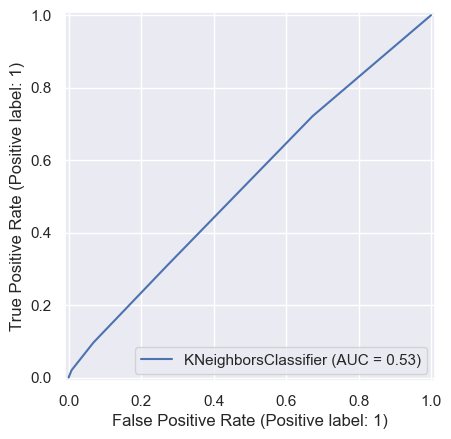

In [83]:
svc_disp = RocCurveDisplay.from_estimator(knn, X_test, y_test)

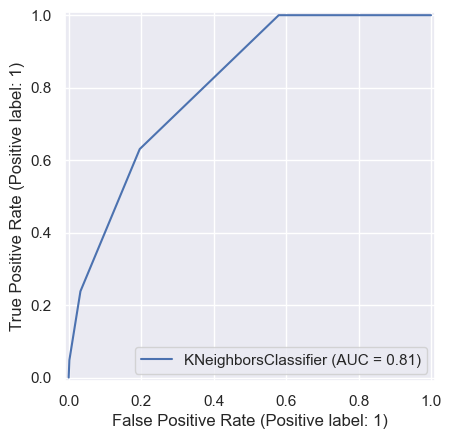

In [85]:
svc_disp = RocCurveDisplay.from_estimator(knn, X_train, y_train)

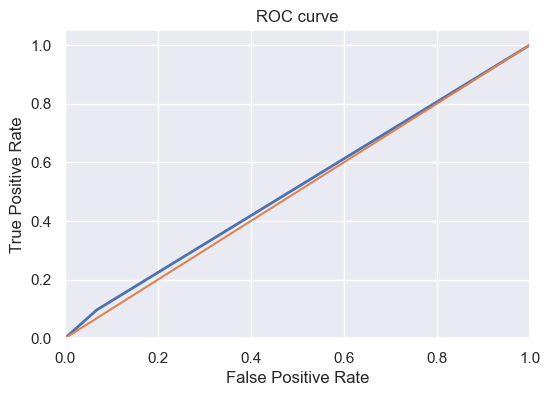

In [87]:
sns.set(font_scale=1)
sns.set_color_codes("muted")

plt.figure(figsize=(6, 4))
fpr, tpr, thresholds = roc_curve(y_test, y_test_predict, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

### Gaussian Naive Bayes (НАИВНЫЙ БАЙЕСОВСКИЙ КЛАССИФИКАТОР)

In [90]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [92]:
# performance measurement
gnb_pred_test = gnb.predict(X_test)
gnb_cm = confusion_matrix(y_test, gnb_pred_test)
gnb_accuracy = accuracy_score(y_test, gnb_pred_test)
gnb_error_rate = 1 - gnb_accuracy
gnb_precision_score = precision_score(y_test, gnb_pred_test)
gnb_recall = recall_score(y_test, gnb_pred_test)
gnb_roc_auc_score = roc_auc_score(y_test, gnb_pred_test, average='macro')

y_train_predict = gnb.predict(X_train)
y_test_predict = gnb.predict(X_test)

print('train accuracy: ', accuracy_score(y_train, y_train_predict, normalize=True))
print('test accuracy: ', accuracy_score(y_test, y_test_predict, normalize=True))
print(classification_report(y_test, gnb_pred_test))

train accuracy:  0.7822388059701493
test accuracy:  0.7948484848484848
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      2657
           1       0.38      0.08      0.14       643

    accuracy                           0.79      3300
   macro avg       0.60      0.52      0.51      3300
weighted avg       0.73      0.79      0.74      3300



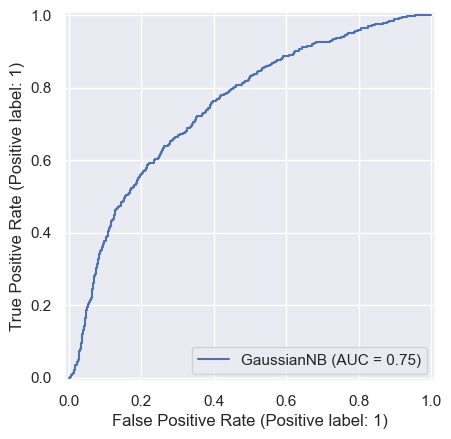

In [94]:
svc_disp = RocCurveDisplay.from_estimator(gnb, X_test, y_test)

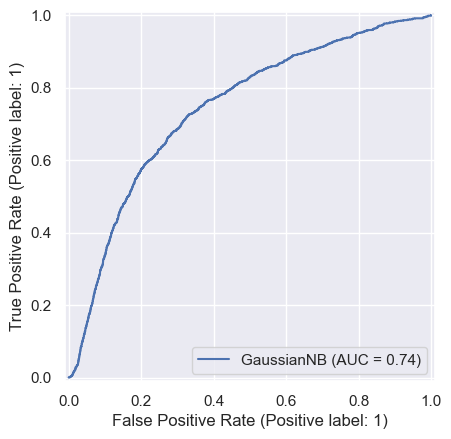

In [96]:
svc_disp = RocCurveDisplay.from_estimator(gnb, X_train, y_train)

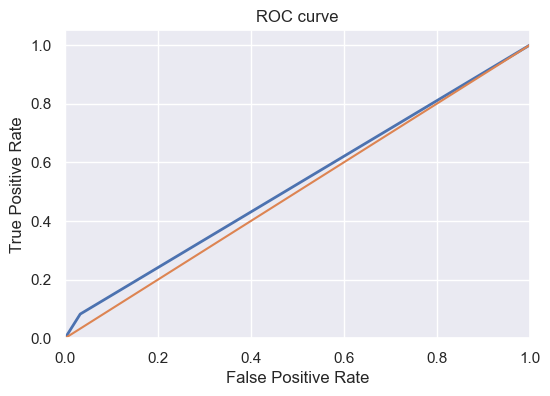

In [98]:
sns.set(font_scale=1)
sns.set_color_codes("muted")

plt.figure(figsize=(6, 4))
fpr, tpr, thresholds = roc_curve(y_test, y_test_predict, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

### Random Forest Classifier (Классификатор дерева решений)

In [103]:
rfc  = RandomForestClassifier(criterion = 'gini',
                                    n_estimators = 100,
                                    max_depth = 9,
                                    random_state = 42,
                                    n_jobs = -1)

rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, n_jobs=-1, random_state=42)

In [105]:
# performance measurement
rfc_pred_test = rfc.predict(X_test)
rfc_cm = confusion_matrix(y_test, rfc_pred_test)
rfc_accuracy = accuracy_score(y_test, rfc_pred_test)
rfc_error_rate = 1 - rfc_accuracy
rfc_precision_score = precision_score(y_test, rfc_pred_test)
rfc_recall = recall_score(y_test, rfc_pred_test)
rfc_roc_auc_score = roc_auc_score(y_test, rfc_pred_test, average='macro')

y_train_predict = rfc.predict(X_train)
y_test_predict = rfc.predict(X_test)

print('train accuracy: ', accuracy_score(y_train, y_train_predict, normalize=True))
print('test accuracy: ', accuracy_score(y_test, y_test_predict, normalize=True))
print(classification_report(y_test, rfc_pred_test))

train accuracy:  0.8901492537313432
test accuracy:  0.8709090909090909
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2657
           1       0.78      0.47      0.58       643

    accuracy                           0.87      3300
   macro avg       0.83      0.72      0.75      3300
weighted avg       0.86      0.87      0.86      3300



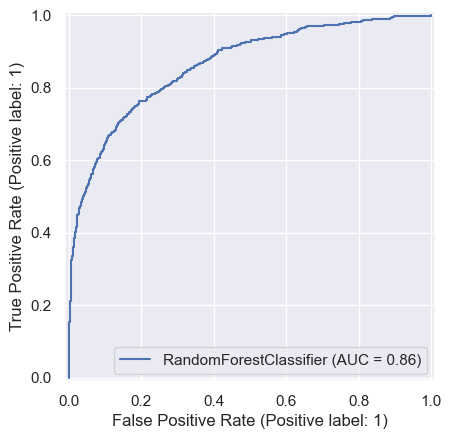

In [107]:
svc_disp = RocCurveDisplay.from_estimator(rfc, X_test, y_test)

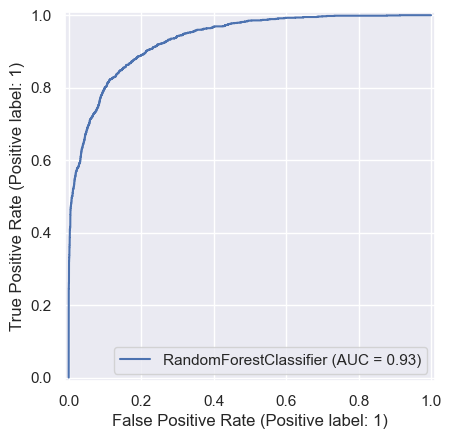

In [109]:
svc_disp = RocCurveDisplay.from_estimator(rfc, X_train, y_train)

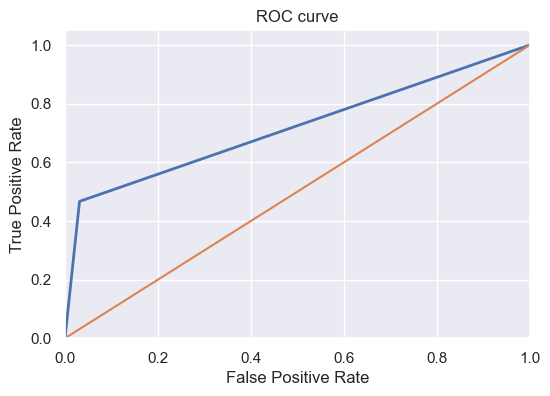

In [111]:
sns.set(font_scale=1)
sns.set_color_codes("muted")

plt.figure(figsize=(6, 4))
fpr, tpr, thresholds = roc_curve(y_test, y_test_predict, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

### Logistic Regression (Логистическая регрессия)

In [114]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [116]:
lr = LogisticRegression(random_state = 42)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [118]:
# performance measurement
lr_pred_test = lr.predict(X_test)
lr_cm = confusion_matrix(y_test, lr_pred_test)
lr_accuracy = accuracy_score(y_test, lr_pred_test)
lr_error_rate = 1 - lr_accuracy
lr_precision_score = precision_score(y_test, lr_pred_test)
lr_recall = recall_score(y_test, lr_pred_test)
lr_roc_auc_score = roc_auc_score(y_test, lr_pred_test, average='macro')

y_train_predict = lr.predict(X_train)
y_test_predict = lr.predict(X_test)

print('train accuracy: ', accuracy_score(y_train, y_train_predict, normalize=True))
print('test accuracy: ', accuracy_score(y_test, y_test_predict, normalize=True))
print(classification_report(y_test, lr_pred_test))

train accuracy:  0.81
test accuracy:  0.8181818181818182
              precision    recall  f1-score   support

           0       0.83      0.97      0.90      2657
           1       0.60      0.20      0.30       643

    accuracy                           0.82      3300
   macro avg       0.72      0.59      0.60      3300
weighted avg       0.79      0.82      0.78      3300



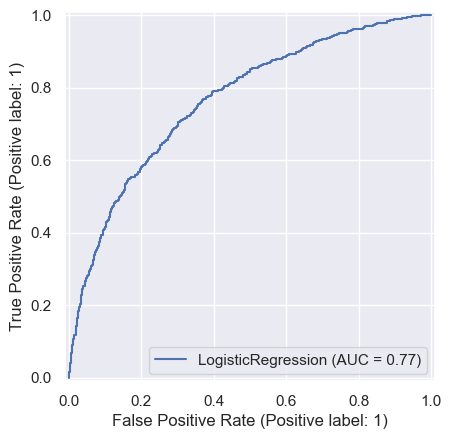

In [120]:
svc_disp = RocCurveDisplay.from_estimator(lr, X_test, y_test)

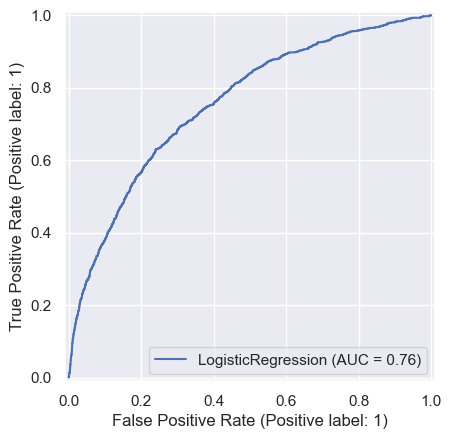

In [122]:
svc_disp = RocCurveDisplay.from_estimator(lr, X_train, y_train)

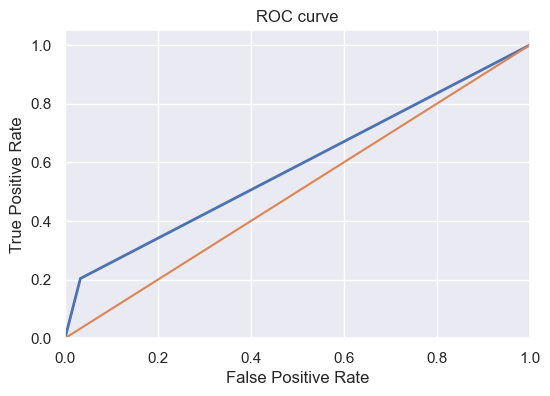

In [124]:
sns.set(font_scale=1)
sns.set_color_codes("muted")

plt.figure(figsize=(6, 4))
fpr, tpr, thresholds = roc_curve(y_test, y_test_predict, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

### Сравнение метрик

In [127]:
classifiers =["KNeighborsClassifier", "Gaussian Naive Bayes", "Random Forest Classifier", "Logistic Regression"]

log_cols = ["Classifier", "Accuracy", "Error Rate", "Precision", "Recall", "AUC Score"]
log = pd.DataFrame(columns=log_cols)

log["Classifier"] = classifiers
log["Accuracy"] = [knn_accuracy, gnb_accuracy, rfc_accuracy, lr_accuracy]
log["Error Rate"] = [knn_error_rate, gnb_error_rate, rfc_error_rate, lr_error_rate]
log["Precision"] = [knn_precision_score, gnb_precision_score, rfc_precision_score, lr_precision_score,]
log["Recall"] = [knn_recall, gnb_recall, rfc_recall, lr_recall]
log["AUC Score"] = [knn_roc_auc_score, gnb_roc_auc_score, rfc_roc_auc_score, lr_roc_auc_score]

log

,Classifier,Accuracy,Error Rate,Precision,Recall,AUC Score
0,KNeighborsClassifier,0.769091,0.230909,0.255144,0.096423,0.514151
1,Gaussian Naive Bayes,0.794848,0.205152,0.378571,0.082426,0.524841
2,Random Forest Classifier,0.870909,0.129091,0.783290,0.466563,0.717662
3,Logistic Regression,0.818182,0.181818,0.598174,0.203733,0.585306


### Confusion matrix (матрица ошибок)

In [164]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [166]:
cm = confusion_matrix(y_test, y_test_predict)
cm

array([[2569,   88],
       [ 512,  131]], dtype=int64)

### Accuracy (Точность)

In [169]:
print('test accuracy: ', accuracy_score(y_test, y_test_predict, normalize=True))

test accuracy:  0.8181818181818182


### Precision (точность) 

In [155]:
print('test precision_score: ', precision_score(y_test, y_test_predict))

test precision_score:  0.5981735159817352


### Recall (полнота)

In [157]:
print('test recall_score: ', recall_score(y_test, y_test_predict))

test recall_score:  0.20373250388802489


### F1-score

In [159]:
print('test f1_score: ', f1_score(y_test, y_test_predict))

test f1_score:  0.3039443155452436


### Полная информация

In [161]:
print(classification_report( y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.83      0.97      0.90      2657
           1       0.60      0.20      0.30       643

    accuracy                           0.82      3300
   macro avg       0.72      0.59      0.60      3300
weighted avg       0.79      0.82      0.78      3300

